In [2]:
!pip install brian2
!pip install tensorflow
!pip install ipympl
!pip install --upgrade numpy
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 KB 28.2 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 52.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.2 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import brian2 as b2
from brian2.monitors.spikemonitor import SpikeMonitor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, f1_score
import pandas as pd
import seaborn as sn
import math
import os
from tensorflow.keras.datasets import mnist
# import ipdb # ipdb.set_trace() ### breakpoint
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget
#%matplotlib inline
b2.core.preferences.prefs.codegen.target = "numpy"

b2.defaultclock.dt = 0.05 * b2.ms

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Parameters

In [18]:
nn = 2
n_train = 2
n_test = 50

n_epoch = n_train // 2

min_spike_time = 1 # ms
max_spike_time = 9 # ms   

transfer_time_max = 8 * b2.ms 
transfer_time_min = 0.5 * b2.ms
myelin_max = 4 * b2.um # um = microns = micro meters
myelin_min = 0.3 * b2.um

tau_const = 3.5
tau_min = 3.45 * b2.ms 
tau_max = 3.55 * b2.ms 
learning_rate = 0.3

repeat = 10
train_period = 30 * b2.ms 
time_relax = 60 * b2.ms

ni = 28*28

file_path_final_myelin = 'final_myelin.npy'
file_path_init_myelin = 'init_myelin.npy'
file_path_tau = 'tau_values.npy'
file_path_0 = 'data_0.npy'
file_path_1 = 'data_plus.npy'

### Functions

In [20]:
%matplotlib widget

def Data_Encoding(data):
    data_spike_time = np.empty(shape = [0, ni])
    for data_i in data:
        data_new = np.clip(- (max_spike_time - min_spike_time) * data_i.reshape(-1) + max_spike_time , min_spike_time, max_spike_time)
        data_spike_time = np.vstack([data_spike_time, data_new])
    return data_spike_time

def show_plots(e_state_mon, e_spike_mon, ind_input, initial_myelin, final_myelin):
    n_plot = len(ind_input)
    # plot the evolution of membrane potential 
    plt.figure(figsize = (16, 8))
    for ind, n in enumerate(ind_input):
        if (ind==0): sp1 = plt.subplot(n_plot,1,1) # make equal scales
        else: plt.subplot(n_plot,1,ind+1, sharex=sp1, sharey=sp1)
        plt.plot(e_state_mon.t/b2.ms, e_state_mon.v[n]/b2.mV, label='$v$')
        plt.plot(e_state_mon.t/b2.ms, e_state_mon.vt_n[n]/b2.mV , label='$v_T$')
        # for t in i_spike_mon.t:
        #     plt.axvline(t/b2.ms, ls='--', c='C1', lw=1) # orange == input
        for t in e_spike_mon.spike_trains()[n]:
            plt.axvline(t/b2.ms, ls='--', c='C2', lw=1) # green == main
        # for t in e_event_mon.event_trains()[n]:
        #     plt.axvline(t/b2.ms, ls='--', c='C3', lw=1) # red == suppress_event
        plt.legend()
        plt.grid()
        plt.xlabel("$t$, ms")
        plt.ylabel(f"n={n}")

    # plot the evolution of g_n 
    plt.figure(figsize = (16, 8))
    for ind, n in enumerate(ind_input):
        if (ind==0): sp1 = plt.subplot(n_plot,1,1) # make equal scales
        else: plt.subplot(n_plot,1,ind+1, sharex=sp1, sharey=sp1)
        plt.plot(e_state_mon.t/b2.ms, e_state_mon.g_n[n] , label='$g_n$')
        # for t in i_spike_mon.t:
        #     plt.axvline(t/b2.ms, ls='--', c='C1', lw=1) # orange == input
        for t in e_spike_mon.spike_trains()[n]:
            plt.axvline(t/b2.ms, ls='--', c='C2', lw=1) # green == main
        plt.legend()
        plt.grid()
        plt.xlabel("$t$, ms")
        plt.ylabel(f"n={n}")

def plot_v_g_n(e_state_mon, e_spike_mon, ind_input):
    n_plot = len(ind_input)
    plt.figure(figsize = (16, 8))
    for ind, n in enumerate(ind_input):
        if (ind==0): sp1 = plt.subplot(n_plot,1,1) # make equal scales
        else: plt.subplot(n_plot,1,ind+1, sharex=sp1, sharey=sp1)
        plt.plot(e_state_mon.t/b2.ms, e_state_mon.v[ind]/b2.mV, label='$v$')
        plt.plot(e_state_mon.t/b2.ms, e_state_mon.vt_n[ind]/b2.mV , label='$v_T$')
        for t in e_spike_mon.spike_trains()[ind]:
            plt.axvline(t/b2.ms, ls='--', c='C2', lw=1) # green == main
        plt.legend()
        plt.grid()
        plt.xlabel("$t$, ms")
        plt.ylabel(f"n={ind}")
    # for ind in ind_input:
    #     plt.figure(figsize = (8, 2))
    #     plt.plot(e_state_mon.t/b2.ms, e_state_mon.g_n[ind] , label='$g_n$')
    #     for t in e_spike_mon.spike_trains()[ind]:
    #         plt.axvline(t/b2.ms, ls='--', c='C2', lw=1) # green == main
    #     plt.legend()
    #     plt.xlabel("$t$, ms")
    #     plt.ylabel(f"n={ind}")

def plot_steps_myelin(current_myelin, ind_input):
    for m in current_myelin:
        for ind in ind_input:
            plt.figure(figsize = (6, 2))
            plt.imshow(m[ind].reshape(round(np.sqrt(ni)), round(np.sqrt(ni))), cmap='gray')
            plt.title(f"n={ind} final myelin")
            plt.colorbar()

def test(snn, times_sample, ind):
    test_mon = SpikeMonitor(snn.group_n)
    snn.net.add(test_mon)
    snn.input_group.set_spikes(list(range(ni)), times_sample * b2.ms + ind*train_period + ind*time_relax)
    snn.net.run(train_period)
    snn.input_group.set_spikes(list(range(ni)), [30000]*ni * b2.ms, 0 * b2.ms)
    snn.net.run(time_relax)
    snn.net.remove(test_mon)
    return test_mon.count

def CreateClasses(snn, train_0_spike_time, train_1_spike_time, plot = None):
    if plot: 
        e_state_mon = b2.StateMonitor(snn.group_n, ['v', 'vt_n', 'g_n'], record=True)
        spike_mon = SpikeMonitor(snn.group_n)
        snn.net.add(e_state_mon, spike_mon)
    spike_num_0 = np.zeros([nn])
    spike_num_1 = np.zeros([nn])
    classes = {}
    for i in range(n_epoch):
        count = np.asarray(test(snn, train_0_spike_time[i], 2*i))
        spike_num_0 += count
        if np.any(count != 0): 
            for j in range(len(count)): 
                if count[j] > 0: classes[j] = "0"
        count = np.asarray(test(snn, train_1_spike_time[i], 2*i+1))
        spike_num_1 += count
        if np.any(count != 0):
            for j in range(len(count)): 
                if count[j] > 0: classes[j] = "1"
        if i % 10 == 0: print(f'Epoch done: {i} / {n_epoch}')
    for i in range(nn):
        if i not in classes.keys(): classes[i] = "None"
    print(classes)
    print(spike_num_0, spike_num_1)
    if plot: 
        plot_v_g_n(e_state_mon, spike_mon)
        snn.net.remove(e_state_mon, spike_mon)
    return classes

def predict(snn, test_times, classes, plot = None):
    if plot:
        e_state_mon = b2.StateMonitor(snn.group_n, ['v', 'vt_n', 'g_n'], record=True)
        spike_mon = SpikeMonitor(snn.group_n)
        snn.net.add(e_state_mon, spike_mon)
    pred = []
    for ind, times_sample in enumerate(test_times):
        spike_num = np.asarray(test(snn, times_sample, ind))
        num_0 = 0        
        num_1 = 0
        for i in range(len(spike_num)):
            if classes[i] == "0":
                num_0 += spike_num[i]
            elif classes[i] == "1":
                num_1 += spike_num[i]
        if num_0 > num_1: pred += ["0"]
        elif num_0 < num_1: pred += ["1"]
        elif np.sum(spike_num) == 0: pred += ["None"] 
        else: pred += ["m_n_0.5"] # m_n_0.5 - many neurons, acc = 0.5
        if ind % 10 == 0: print(f'Test epoch done: {ind} / {n_test}')
    if plot: 
        plot_v_g_n(e_state_mon, spike_mon)
        snn.net.remove(e_state_mon, spike_mon)
    return pred

def show_confusion_matrix(pred, labels):
    data = {'y_Actual': labels, 'y_Predicted': pred}
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    plt.figure(figsize = (4, 3))
    sn.heatmap(confusion_matrix, annot=True)

def show_wrong_pics(pred, labels, test_pics):
    is_wrong_ind = np.array(pred) != np.array(labels)
    for i in range(len(is_wrong_ind)):
        if is_wrong_ind[i]:
            plt.figure(figsize = (4, 4))
            plt.imshow(test_pics[i].reshape(round(np.sqrt(ni)), round(np.sqrt(ni))), cmap='gray')
            plt.xlabel(f"Actual: {labels[i]}, Predicted: {pred[i]}")
            plt.title(f"Wrong recognized pic: {i}")
            plt.colorbar()

def analyse(pred, labels):
    precision = accuracy_score(labels, pred)
    recall = recall_score(labels, pred, average='micro')
    F1_score = f1_score(labels, pred, average='micro')
    return precision, recall, F1_score 


### Model SNN

In [19]:
class SNN:
    def __init__(self, nn, ni, train_mode, init_myelin, tau_values): 

        # Input_group neurons
        times = [0]*ni * b2.ms
        self.input_group = b2.SpikeGeneratorGroup(ni, list(range(ni)), times, name = "input_group")

        # Main neurons
        model_n = '''
          dv/dt = (v_rest_n - v + g_n * (E_exc_n - v)) / tau_n : volt
          tau_n : second
          vt_n : volt
          v_rest_n : volt
          v_reset_n : volt
          E_exc_n : volt
          g_n : 1
          r_n : meter/second 
          train_mode_n : 1
          k : 1
          '''
        self.group_n = b2.NeuronGroup(nn, model=model_n, threshold='v>vt_n', reset='v=v_reset_n', 
          refractory=max_spike_time*b2.ms, method='euler', events = {"suppress_event" : "v < v_reset_n"})
        self.group_n.train_mode_n = train_mode
        self.group_n.tau_n = tau_values # tau_const * b2.ms 
        self.group_n.vt_n = -52 * b2.mV
        self.group_n.v_rest_n = -65 * b2.mV
        self.group_n.v_reset_n = self.group_n.v_rest_n
        self.group_n.v = self.group_n.v_rest_n
        self.group_n.g_n = 0
        self.group_n.r_n = 0 * b2.meter/b2.second 
        self.group_n.E_exc_n = 0 * b2.mV
        self.group_n.k = learning_rate 

        # EXCISITORY synapses 
        model_e = '''
          g = g_amp * exp((tpre + transfer_time - t) / tau_s) * int((t >= tpre + transfer_time) and (tpre >= 0 * ms)) : 1
          g_n_post = g : 1 (summed)
          r = r_amp * int(t >= tpre + transfer_time) * int(tpre >= 0 * ms) : meter/second 
          r_n_post = r / n_sp : meter/second (summed)
          transfer_time : second
          dmyelin/dt = train_mode_e * k * abs(r_n_post - r) * (int(r_n_post > r) - (myelin-myelin_min)/(myelin_max-myelin_min)) : meter (clock-driven)
          myelin_memory : meter
          tau_s : second
          g_amp : 1
          r_amp : meter/second 
          tpre : second
          n_sp : 1
          train_mode_e : 1
          ''' 
        on_pre_e = '''
          tpre = t
          transfer_time = (-(transfer_time_max - transfer_time_min)*myelin + transfer_time_max*myelin_max - transfer_time_min*myelin_min)/(myelin_max - myelin_min)
          '''
        on_post_e = { 
          "post" : '''
            myelin_memory = myelin
            k = k * 0.9
            ''', 
          "suppress" : '''
            myelin = myelin_memory
            ''' }
        # n_sp 0 -- 176, n_sp 1 -- 96 
        # 13/150 = 0.087, 4.5/ 150 /(3.5/8) = 0.069 -- only 0
        # 13/105 = 0.124, 4.5/ 105 /(3.5/8) = 0.098 -- 0 & 1
        self.synapses_e = b2.Synapses(self.input_group, self.group_n, model=model_e, on_pre=on_pre_e, 
          on_post=on_post_e, method='euler', on_event={"suppress" : "suppress_event"})
        self.synapses_e.connect()
        self.synapses_e.train_mode_e = train_mode
        self.synapses_e.tpre = -1 * b2.ms 
        self.synapses_e.tau_s = tau_const / 8 * b2.ms # tau_const / 8 
        self.synapses_e.n_sp = 105
        self.synapses_e.g_amp = 4.5 / self.synapses_e.n_sp 
        self.synapses_e.myelin = init_myelin
        self.synapses_e.myelin_memory = init_myelin
        self.synapses_e.transfer_time = (-(transfer_time_max - transfer_time_min)*init_myelin + transfer_time_max*myelin_max - transfer_time_min*myelin_min)/(myelin_max - myelin_min)
        self.synapses_e.r_amp = 1 * b2.um/b2.ms 

        # INHIBITORY synapses
        model_i = '''
          delta_v_post_i : volt
          '''
        on_pre_i = '''
          v_post -= delta_v_post_i
          '''
        self.synapses_i = b2.Synapses(self.group_n, self.group_n, model=model_i, on_pre=on_pre_i, method='euler')
        self.synapses_i.connect(condition='i != j')
        self.synapses_i.delta_v_post_i = 20 * b2.mV

        self.net = b2.Network(self.input_group, self.group_n, self.synapses_e, self.synapses_i)
    
    def reset_fnc(self):
        self.synapses_e.tpre = -1 * b2.ms

### Data loading

In [5]:
current_dir = os.getcwd()
(train_X, train_Y), (test_X, test_Y) = mnist.load_data(path = current_dir+'\mnist.npz')

train_0_full = train_X[train_Y == 0] / 255
train_1_full = train_X[train_Y == 1] / 255
test_0_full = test_X[test_Y == 0] / 255
test_1_full = test_X[test_Y == 1] / 255

print(len(train_0_full))
print(len(train_1_full))
print(len(test_0_full))
print(len(test_1_full))

train_0 = train_0_full[0:n_epoch]
train_1 = train_1_full[0:n_epoch]

11490434/11490434 [==============================] - 0s 0us/step
5923
6742
980
1135


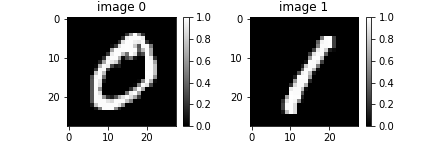

In [6]:
plt.figure(figsize = (6, 2))
plt.subplot(1,2,1)
plt.imshow(train_0[0], cmap='gray')
plt.title("image 0")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(train_1[0], cmap='gray')
plt.title("image 1")
plt.colorbar()

Encoding

In [7]:
train_0_spike_time = Data_Encoding(train_0)
train_1_spike_time = Data_Encoding(train_1)

# for i in range(1): 
#     plt.figure(figsize = (8, 2))
#     plt.subplot(1,2,1)
#     plt.imshow(train_0_spike_time[i].reshape(round(np.sqrt(ni)), round(np.sqrt(ni))), cmap='gray')
#     plt.title("Data image x")
#     plt.colorbar()
#     plt.subplot(1,2,2)
#     plt.imshow(train_1_spike_time[i].reshape(round(np.sqrt(ni)), round(np.sqrt(ni))), cmap='gray')
#     plt.title("Data image plus")
#     plt.colorbar()

### Training and testing

In [21]:
# if os.path.exists(file_path_init_myelin):
#     with open(file_path_init_myelin, 'rb') as f:
#         init_myelin = np.load(f) * b2.meter
# else:
#     init_myelin = np.random.uniform(myelin_min, myelin_max, ni*nn) * b2.meter
#     np.save(file_path_init_myelin, init_myelin)

# if os.path.exists(file_path_tau):
#     with open(file_path_tau, 'rb') as f:
#         tau_values = np.load(f) * b2.second
# else: 
#     tau_values = np.random.uniform(tau_min, tau_max, nn) * b2.second
#     np.save(file_path_tau, tau_values)

init_myelin = np.random.uniform(myelin_min, myelin_max, ni*nn) * b2.meter
np.save(file_path_init_myelin, init_myelin)

# tau_values = np.random.uniform(tau_min, tau_max, nn) * b2.second
# np.save(file_path_tau, tau_values)

tau_values = 3.5 * b2.ms 

print(tau_values)

3.5 ms


In [ ]:
# print([tau_values[10], tau_values[14], tau_values[16], tau_values[17], tau_values[19]])

Training

In [22]:
snn = SNN(nn, ni, 1, init_myelin, tau_values)

e_state_mon = b2.StateMonitor(snn.group_n, ['v', 'vt_n', 'g_n', 'r_n'], record=True)
e_spike_mon = b2.SpikeMonitor(snn.group_n)
snn.net.add(e_state_mon, e_spike_mon)

import time 
start = time.time()

current_myelin = []
train_matr = []

for epoch in range(n_epoch):
    more_time = epoch*2*(repeat*train_period + time_relax)

    spike_mon = b2.SpikeMonitor(snn.group_n)
    snn.net.add(spike_mon)
    for ind in range(repeat):
        light_spikes_0 = np.array([[n_ind, sp_time] for n_ind, sp_time in enumerate(train_0_spike_time[epoch]) if sp_time != max_spike_time])
        snn.input_group.set_spikes(light_spikes_0[:,0], light_spikes_0[:,1] * b2.ms + ind*train_period + more_time)
        snn.net.run(train_period)
        snn.reset_fnc()
    snn.input_group.set_spikes(list(range(ni)), [30000]*ni * b2.ms, 0 * b2.ms)
    snn.net.run(time_relax)
    count_0 = np.asarray(spike_mon.count)
    snn.net.remove(spike_mon)

    current_myelin.append(np.array((snn.synapses_e.myelin/b2.um)).reshape(ni, nn).transpose())

    spike_mon = b2.SpikeMonitor(snn.group_n)
    snn.net.add(spike_mon)
    for ind in range(repeat):
        light_spikes_1 = np.array([[n_ind, sp_time] for n_ind, sp_time in enumerate(train_1_spike_time[epoch]) if sp_time != max_spike_time])
        snn.input_group.set_spikes(light_spikes_1[:,0], light_spikes_1[:,1] * b2.ms + (repeat + ind)*train_period + time_relax + more_time)
        snn.net.run(train_period)
        snn.reset_fnc()
    snn.input_group.set_spikes(list(range(ni)), [30000]*ni * b2.ms, 0 * b2.ms)
    snn.net.run(time_relax)
    count_1 = np.asarray(spike_mon.count)
    snn.net.remove(spike_mon)

    # print(f"0: {count_0}")
    # print(f"1: {count_1}")
    train_matr.append(count_0)
    train_matr.append(count_1)
    current_myelin.append(np.array((snn.synapses_e.myelin/b2.um)).reshape(ni, nn).transpose())
    if epoch % 10 == 0: print(f'Epoch done: {epoch} / {n_epoch}')


end = time.time() - start 
print("Training time: ", end)

np.save(file_path_final_myelin, snn.synapses_e.myelin)

initial_myelin = (init_myelin/b2.um).reshape(ni, nn).transpose()
final_myelin = np.array((snn.synapses_e.myelin/b2.um)).reshape(ni, nn).transpose()

Epoch done: 0 / 1
Training time:  8.669704675674438


In [23]:
matr = np.vstack([np.arange(nn), np.array(train_matr)]) 
print(matr)

[[ 0  1]
 [20 20]
 [10 20]]


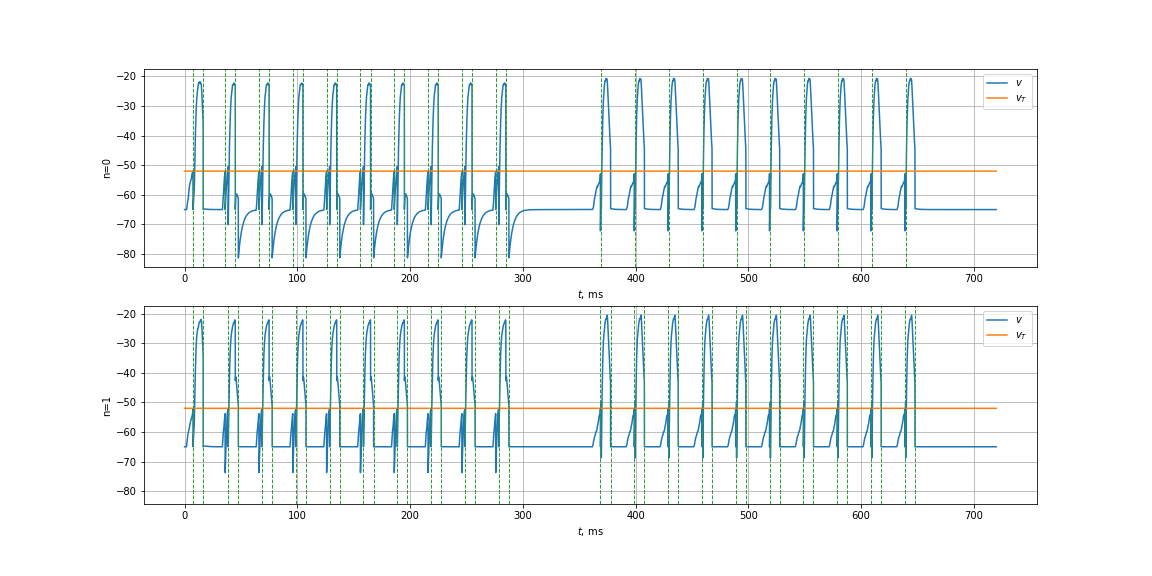

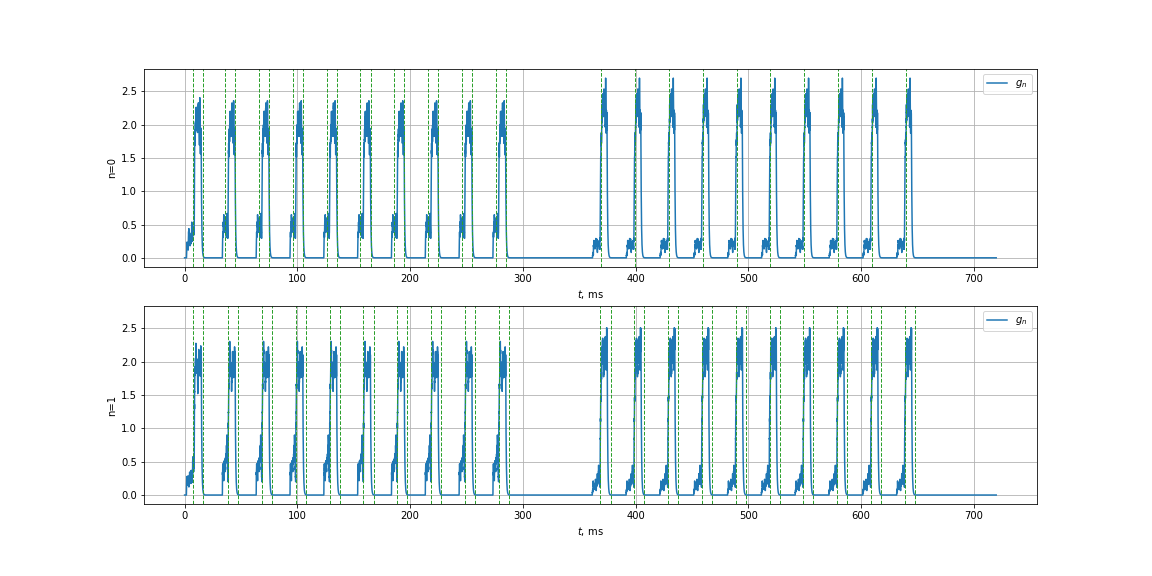

In [24]:
ind_input_to_show = [0, 1]
show_plots(e_state_mon, e_spike_mon, ind_input_to_show, initial_myelin, final_myelin)

In [ ]:
# snn.net.remove(e_state_mon, e_spike_mon)

Myelin changing

In [ ]:
# ind_input = [0]
# plot_steps_myelin(current_myelin, ind_input)

In [ ]:
# %matplotlib widget

# plt.figure(figsize = (12, 2))
# plt.subplot(1,2,1)
# plt.imshow(train_0[0], cmap='gray')
# plt.title("image 0")
# plt.colorbar()
# plt.subplot(1,2,2)
# plt.imshow(train_1[0], cmap='gray')
# plt.title("image 1")
# plt.colorbar()

# def plot_final_myelin(final_myelin):
#     for i in range(nn):
#         plt.figure(figsize = (3, 2))
#         plt.imshow(final_myelin[i].reshape(round(np.sqrt(ni)), round(np.sqrt(ni))), cmap='gray')
#         plt.title(f"n={i+1} final myelin")
#         plt.colorbar()

# plot_final_myelin(final_myelin)

Classification

In [ ]:
with open(file_path_final_myelin, 'rb') as f:
    myelin_value = np.load(f) * b2.meter
snn = SNN(nn, ni, 0, myelin_value, tau_values)

classes = CreateClasses(snn, train_0_spike_time, train_1_spike_time, plot = False)

Testing

In [ ]:
test_0 = test_0_full[0:n_test//2]
test_1 = test_1_full[0:n_test//2]

test_pics = np.hstack([test_0, test_1]).reshape(n_test, ni)
test_0_spike_time = Data_Encoding(test_0)
test_1_spike_time = Data_Encoding(test_1)
test_times = np.hstack([test_0_spike_time, test_1_spike_time]).reshape(n_test, ni)

labels = ["0", "1"]*(n_test//2)

with open(file_path_final_myelin, 'rb') as f:
    myelin_value = np.load(f) * b2.meter
snn = SNN(nn, ni, 0, myelin_value, tau_values)

pred = predict(snn, test_times, classes, plot = False)
show_confusion_matrix(pred, labels)
# show_wrong_pics(pred, labels, test_pics)
precision, recall, F1_score = analyse(pred, labels)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1_score: ", F1_score) 